### Lay the foundations for analysis

In [17]:
import pandas as pd 
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [3]:
df = pd.read_csv('../Data/BrentOilPrices.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9011 entries, 0 to 9010
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    9011 non-null   object 
 1   Price   9011 non-null   float64
dtypes: float64(1), object(1)
memory usage: 140.9+ KB


In [4]:
df.describe()

,Price
count,9011.000000
mean,48.420782
std,32.860110
min,9.100000
25%,19.050000
50%,38.570000
75%,70.090000
max,143.950000


### Research and compile event data

In [15]:
# Ensure Date is datetime and SORTED (essential for merge_asof)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# 2. DEFINE THE 10 KEY EVENTS (Research-backed for 1988-2024)
events_list = [
    {'Date': '1990-08-02', 'Event_Name': 'Gulf War (Iraq-Kuwait)'},
    {'Date': '1997-07-01', 'Event_Name': 'Asian Financial Crisis'},
    {'Date': '2001-09-11', 'Event_Name': '9/11 Terrorist Attacks'},
    {'Date': '2008-07-11', 'Event_Name': 'Global Financial Crisis'},
    {'Date': '2011-01-25', 'Event_Name': 'Arab Spring (Libya)'},
    {'Date': '2014-11-27', 'Event_Name': 'OPEC Non-Cut Decision'},
    {'Date': '2020-03-08', 'Event_Name': 'Saudi-Russia Price War'},
    {'Date': '2020-04-20', 'Event_Name': 'COVID-19 Demand Shock'},
    {'Date': '2022-02-24', 'Event_Name': 'Russia-Ukraine Invasion'},
    {'Date': '2023-10-07', 'Event_Name': 'Israel-Hamas Conflict'}
]

df_event = pd.DataFrame(events_list)
df_event['Date'] = pd.to_datetime(df_event['Date'])
df_event = df_event.sort_values('Date')

# 3. THE "FUZZY" MERGE (Solves the "No Event" and KeyError issues)
# We use merge_asof because if an event happened on a Sunday, 
# it won't find a row in your price data. This finds the NEAREST trading day.
df_final = pd.merge_asof(
    df, 
    df_event, 
    on='Date', 
    direction='nearest', 
    tolerance=pd.Timedelta('2 days')  # Matches if date is within 48 hours
)

# 4. CLEAN UP THE RESULTS
# The 'tolerance' leaves rows that aren't near events as NaN. We fill those now.
df_final['Event_Name'] = df_final['Event_Name'].fillna('No Event')

# 5. VERIFICATION
matched = df_final[df_final['Event_Name'] != 'No Event']
print(f"--- Verification ---")
print(f"Total price rows: {len(df_final)}")
print(f"Events successfully matched: {len(matched)}")
if len(matched) > 0:
    print("Sample of matched events:")
    print(matched[['Date', 'Event_Name']].tail(5))
else:
    print("WARNING: Still no matches. Check if your Date ranges overlap!")

# 6. SAVE TO CSV
df_final.to_csv('../Data/brent_prices_with_events.csv', index=False)
print("\nFile saved as 'brent_prices_with_events.csv'")

--- Verification ---
Total price rows: 9011
Events successfully matched: 31
Sample of matched events:
           Date               Event_Name
8360 2020-04-22    COVID-19 Demand Shock
8827 2022-02-22  Russia-Ukraine Invasion
8828 2022-02-23  Russia-Ukraine Invasion
8829 2022-02-24  Russia-Ukraine Invasion
8830 2022-02-25  Russia-Ukraine Invasion

File saved as 'brent_prices_with_events.csv'


### Understanding the Model and Data

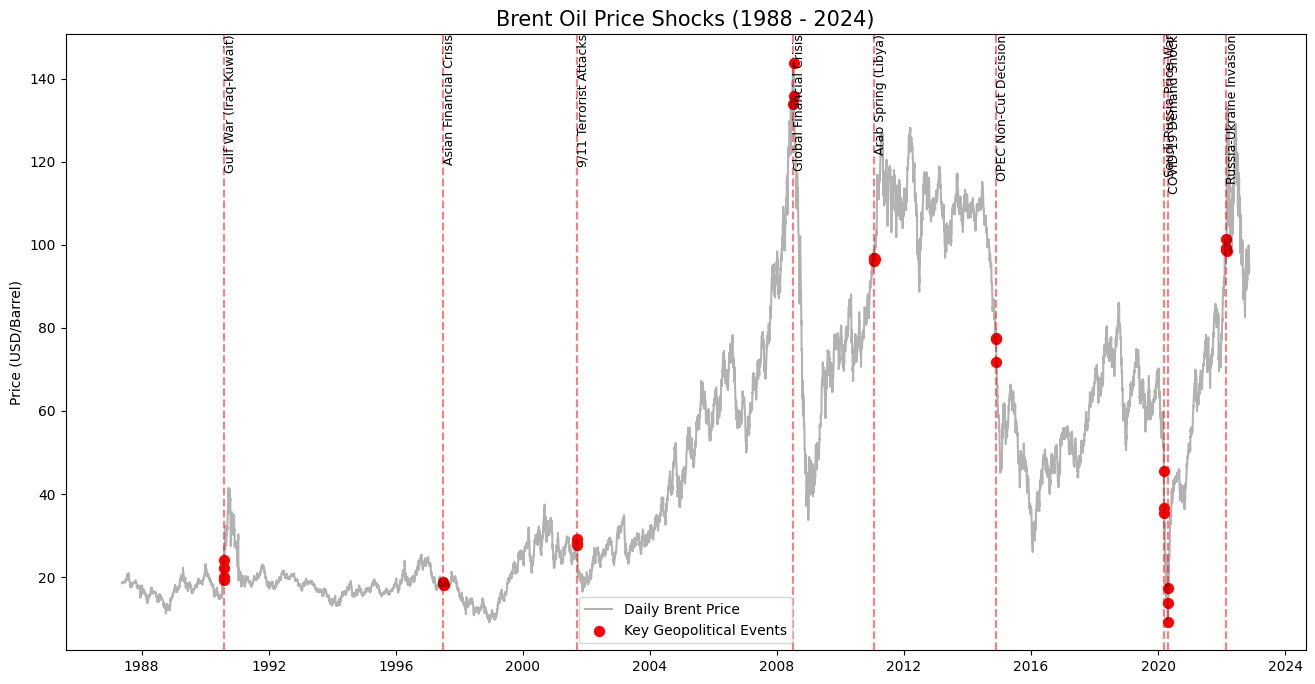

In [18]:
plt.figure(figsize=(16, 8))

# Plot the background price
plt.plot(df_final['Date'], df_final['Price'], color='black', alpha=0.3, label='Daily Brent Price')

# Filter only the events
events_only = df_final[df_final['Event_Name'] != 'No Event']

# Use a scatter plot to "highlight" the event days on the line
plt.scatter(events_only['Date'], events_only['Price'], color='red', s=50, label='Key Geopolitical Events')

# Add vertical lines and labels for the big ones
for i, row in events_only.drop_duplicates(subset=['Event_Name']).iterrows():
    plt.axvline(x=row['Date'], color='red', linestyle='--', alpha=0.5)
    plt.text(row['Date'], plt.ylim()[1], row['Event_Name'], rotation=90, verticalalignment='top', fontsize=9)

plt.title('Brent Oil Price Shocks (1988 - 2024)', fontsize=15)
plt.ylabel('Price (USD/Barrel)')
plt.legend()
plt.show()

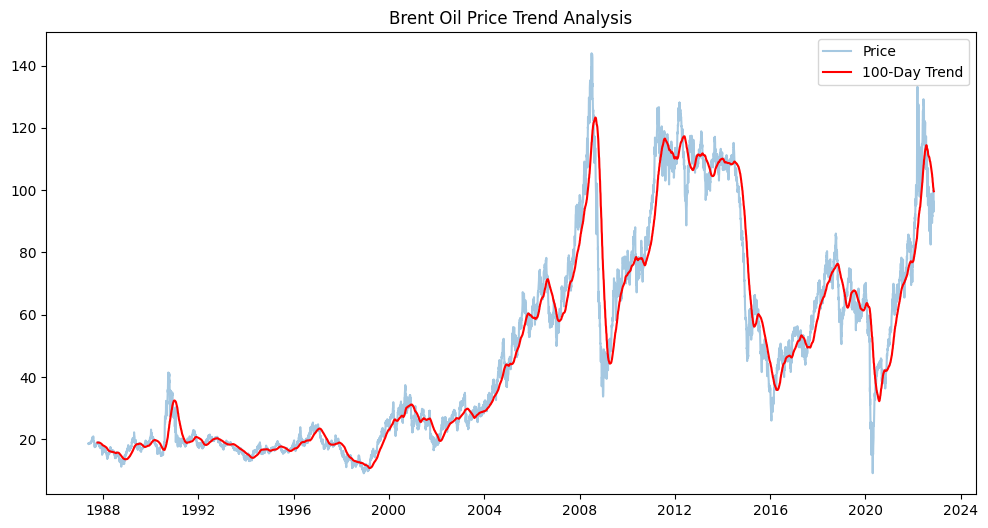

--- Stationarity Test (ADF) ---
ADF Statistic: -1.9938560113924666
p-value: 0.2892735048934033


In [19]:
# Trend Analysis
df['Rolling_Mean'] = df['Price'].rolling(window=100).mean()
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Price'], label='Price', alpha=0.4)
plt.plot(df['Date'], df['Rolling_Mean'], label='100-Day Trend', color='red')
plt.title('Brent Oil Price Trend Analysis')
plt.legend()
plt.show()

# Stationarity Testing (ADF Test)
print("--- Stationarity Test (ADF) ---")
result = adfuller(df['Price'].dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')